### Import libraries


In [1]:
from sklearn.model_selection import train_test_split
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

seed = 7

### Connect to GDrive


In [2]:
from google.colab import drive
drive.mount('/gdrive')

# write path to the folder with trainig_set_no_outliers.npz
%cd '/gdrive/My Drive/My[2024-2025] AN2DL/HW1'

Mounted at /gdrive
/gdrive/My Drive/My[2024-2025] AN2DL/HW1


### Load Data

In [4]:
# to create training set without outliers, first look at the DeleteOutliers.ipynb
data = np.load('trainig_set_no_outliers.npz')
X = data['images']
y = data['labels']
labels = np.unique(y)
print(f'Unique labels are: {labels}')

Unique labels are: [0 1 2 3 4 5 6 7]


### Look at the distribution of Data


(array([ 848., 2177., 1085., 2020.,  849.,  991., 2330., 1643.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

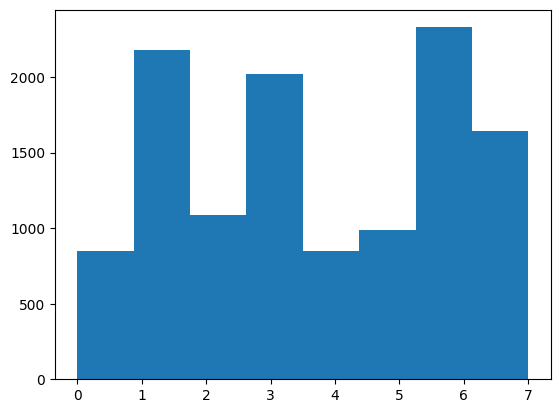

In [6]:
plt.hist(y, bins = 8)

### Normalize Data

In [7]:
if X.max()>1:
  X = (X/255).astype("float32")

print(f'Maximum value of X is {X.max()}')

Maximum value of X is 1.0


### Train Val Test split

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=int(X.shape[0]*0.2),
    random_state=seed,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val,
    y_val,
    test_size=int(X_val.shape[0]*0.2),
    random_state=seed,
    stratify=y_val
)

y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

In [9]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 1.])

### Build the Model

In [10]:
def build_conv_block(x, filters, order_number, kernel_size=3, padding='same',
                downsample=True, activation='relu', name='conv'):
    # Main convolutional path
    x = tfkl.Conv2D(filters, kernel_size, padding=padding,
                    use_bias=False, name=f'{name}_conv_{order_number}')(x)
    x = tfkl.BatchNormalization(name=f'{name}_bn_{order_number}')(x)
    x = tfkl.Activation(activation, name=f'{name}_act_{order_number}')(x)

    # Optional downsampling
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool_{order_number}')(x)

    return x

def build_model(
    input_shape,
    output_shape,
    learning_rate,
    seed=seed
):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    inputs = tfkl.Input(shape=input_shape, name='Input')
    x = tfkl.Resizing(32,32)(inputs)

    x = build_conv_block(x, 32, 1)
    x = build_conv_block(x, 64, 2)

    x = tfkl.Flatten(name='flatten')(x)

    x = tfkl.Dense(units=output_shape, name='dense')(x)
    outputs = tfkl.Activation('softmax', name='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model

### Define the model

In [11]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [12]:
# Number of training epochs
epochs = 1000

# Batch size for training
batch_size = 128

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Epochs: 1000
Batch Size: 128
Learning Rare: 0.001


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ resizing_1 (Resizing)               │ (None, 32, 32, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv_conv_1 (Conv2D)                │ (None, 32, 32, 32)           │           864 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv_bn_1 (BatchNormalization)      │ (None, 32, 32, 32)           │           128 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv_act_1 (Activation)             │ (None, 32, 32, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv_pool_1 (MaxPooling2D)          │ (None, 16, 16, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv_conv_2 (Conv2D)                │ (None, 16, 16, 64)           │        18,432 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv_bn_2 (BatchNormalization)      │ (None, 16, 16, 64)           │           256 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv_act_2 (Activation)             │ (None, 16, 16, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv_pool_2 (MaxPooling2D)          │ (None, 8, 8, 64)             │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 4096)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 8)                    │        32,776 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ softmax (Activation)                │ (None, 8)                    │             0 │    -    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 52,456 (204.91 KB)

 Trainable params: 52,264 (204.16 KB)

 Non-trainable params: 192 (768.00 B)

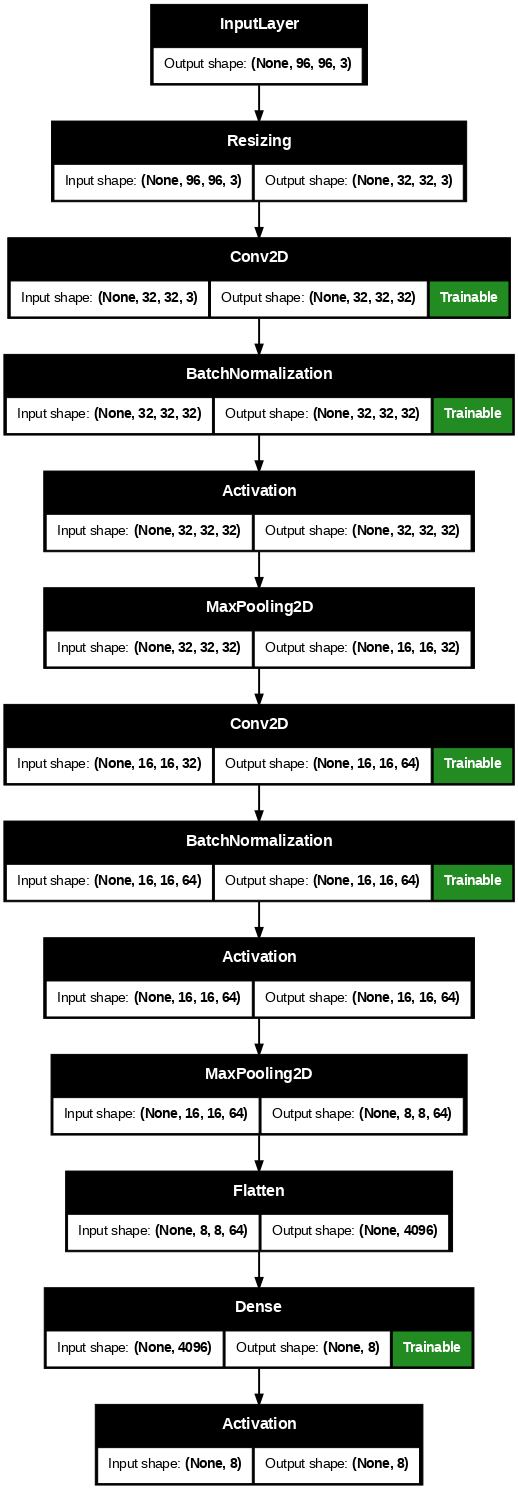

In [14]:
# Build the model with specified input and output shapes
model = build_model(input_shape,
    output_shape,
    learning_rate)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

### Train the model


In [15]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [ ]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'Custom_CNN_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 329ms/step - accuracy: 0.5470 - loss: 1.5339 - val_accuracy: 0.1983 - val_loss: 2.3948
Epoch 2/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 315ms/step - accuracy: 0.8649 - loss: 0.3849 - val_accuracy: 0.1800 - val_loss: 3.1415
Epoch 3/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 321ms/step - accuracy: 0.9140 - loss: 0.2541 - val_accuracy: 0.2240 - val_loss: 3.4838
Epoch 4/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 299ms/step - accuracy: 0.9376 - loss: 0.1918 - val_accuracy: 0.2726 - val_loss: 3.4638
Epoch 5/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 334ms/step - accuracy: 0.9533 - loss: 0.1534 - val_accuracy: 0.3522 - val_loss: 2.8676
Epoch 6/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 305ms/step - accuracy: 0.9587 - loss: 0.1356 - val_accuracy: 0.5699 - val_loss: 1.8982
Epoch 7/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 294ms/step - accuracy: 0.9508 - loss: 0.1452 - val_accuracy: 0.6860 - val_loss: 1.1382
Epoch 8/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - accuracy: 0.9614 - loss: 0

### Plot the training history

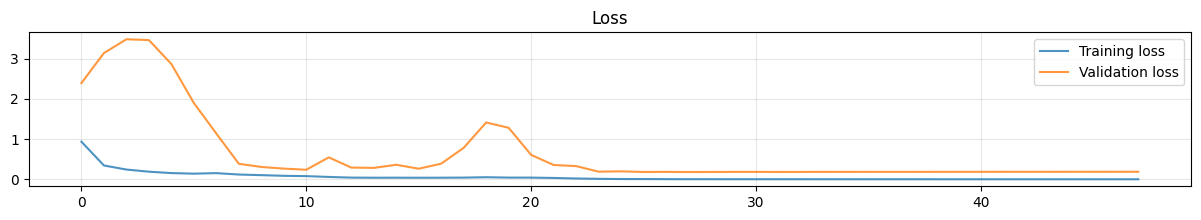

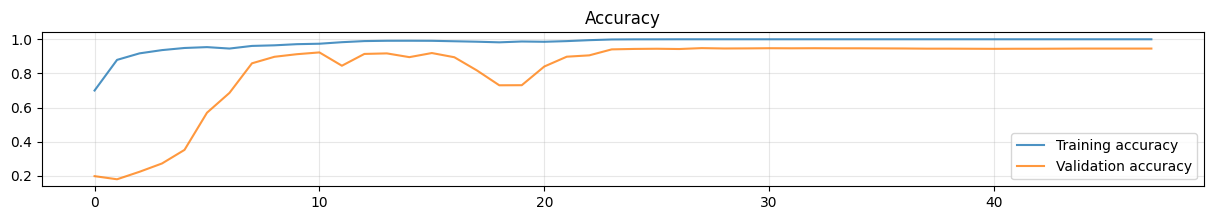

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

### Make inference

In [ ]:
model = tfk.models.load_model('Custom_CNN_94.82.keras')

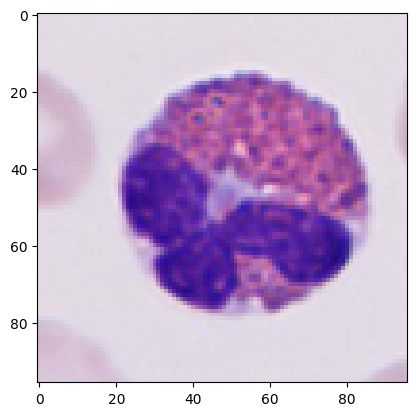

In [ ]:
plt.imshow(X_test[0])

In [ ]:
print(y_test.shape, y_val.shape)

(477, 1) (1911, 8)


In [ ]:
if np.max(X_test)>1:
  X_test = (X_test/255).astype("float32")

predictions = model.predict(X_test, verbose=0)
pred_classes = np.argmax(predictions, axis=-1)
if y_test.shape[1]!=1:
  gt = np.argmax(y_test, axis=1)
else:
  gt = y_test[:, 0]
accuracy = sum(gt == pred_classes) / len(gt)
accuracy

0.9769392033542977

### Simple Submission


In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('Custom_CNN_94.82.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        if np.max(X)>1:
          X = (X/255).astype("float32")
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py 'Custom_CNN_94.82.keras'

from google.colab import files
files.download(filename)

  adding: model.py (deflated 54%)
  adding: Custom_CNN_94.82.keras (deflated 14%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>